In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [24]:
active_passive_dict = np.load('/Users/susannedahle/CellTypeDependenceElStim/simulation_data/active_passive/vmem_amp_data_active_passive_bbp.npy', allow_pickle=True).item()

In [25]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5", 'L4_SS_cADpyr230_1']

cell_cdm_colors = {
    'L4_BP_bIR215_5': "tab:orange",
    "L5_MC_bAC217_1": "tab:blue",
    "L5_TTPC2_cADpyr232_3": "tab:green",
    "L5_NGC_bNAC219_5": 'tab:red',
    'L4_SS_cADpyr230_1': 'tab:purple'
}

cell_base = {
    'L4_BP_bIR215_5': {'name': 'L4 BP', 'color_passive': 'tab:grey', 'color_active': 'tab:orange'},
    'L5_MC_bAC217_1': {'name': 'L5 MC', 'color_passive': 'tab:cyan', 'color_active': 'tab:blue'},
    'L5_TTPC2_cADpyr232_3': {'name': 'L5', 'color_passive': 'tab:olive', 'color_active': 'tab:green'},
    'L5_NGC_bNAC219_5': {'name': 'L5 NGC', 'color_passive': 'tab:brown', 'color_active': 'tab:red'},
    'L4_SS_cADpyr230_1': {'name': 'L4 SS', 'color_passive': 'tab:pink', 'color_active': 'tab:purple'},
}

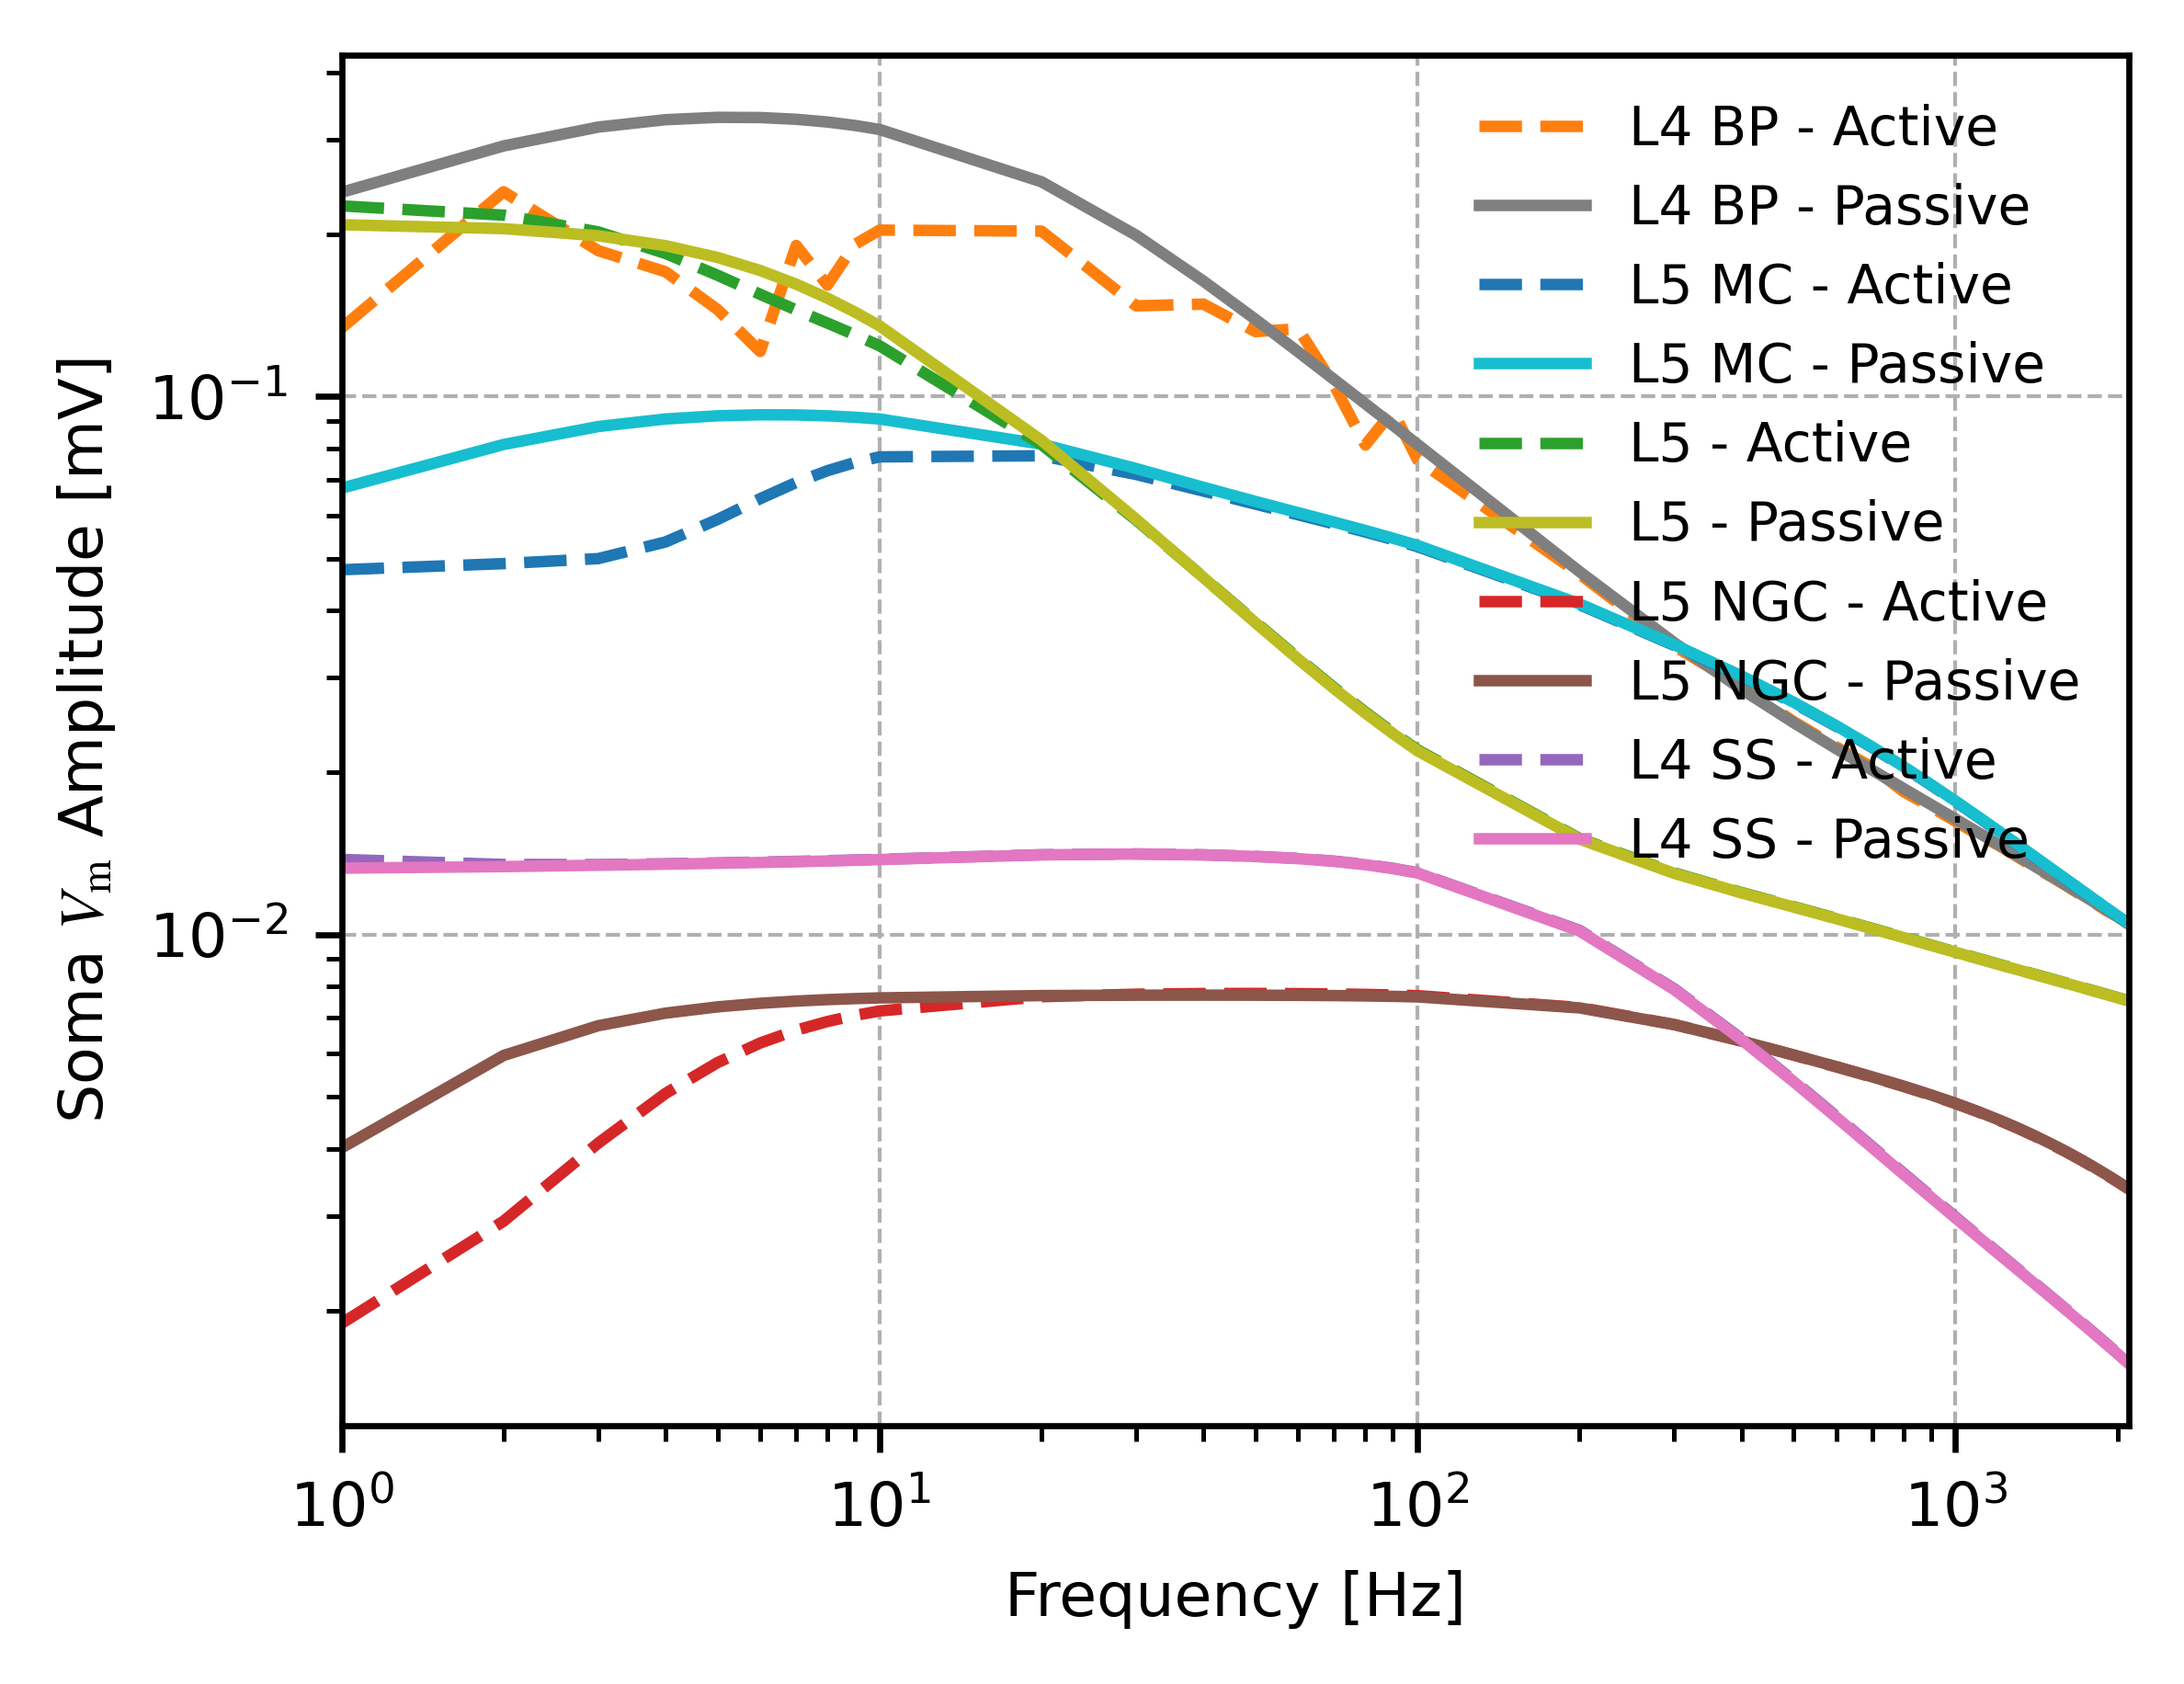

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))

for cell_name, data in active_passive_dict.items():
    frequencies = data['freq']
    amplitudes = data ['soma_amps']

    base, state = cell_name.rsplit('_', 1)
    label = f"{cell_base[base]['name']} - {state.capitalize()}"

    if state == 'active':
        linestyle = '--'
        color = cell_base[base]['color_active']
    else:
        linestyle = '-'
        color = cell_base[base]['color_passive']

    ax.loglog(
        frequencies,
        amplitudes,
        label=label,
        color=color,
        linestyle = linestyle
    )

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Soma $V_\\mathrm{m}$ Amplitude [mV]')
ax.set_xlim(left=frequencies[0], right=frequencies[-1])
ax.grid(linestyle='--', linewidth=0.5)
ax.legend(loc='upper right', fontsize=7, frameon=False)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


In [36]:
plot_data = np.load('/Users/susannedahle/CellTypeDependenceElStim/simulation_data/active_passive/plot_data_active_passive.npy', allow_pickle=True).item()

In [37]:
plot_data.keys()

dict_keys(['L4_BP_bIR215_5_active', 'L4_BP_bIR215_5_passive', 'L5_MC_bAC217_1_active', 'L5_MC_bAC217_1_passive', 'L5_TTPC2_cADpyr232_3_active', 'L5_TTPC2_cADpyr232_3_passive', 'L5_NGC_bNAC219_5_active', 'L5_NGC_bNAC219_5_passive', 'L4_SS_cADpyr230_1_active', 'L4_SS_cADpyr230_1_passive'])

In [46]:
plot_data['L4_BP_bIR215_5_active'].keys()

dict_keys(['freq', 'x', 'z', 'amplitudes', 'totnsegs', 'tvec', 'vmem'])

In [51]:
def plot_cell_shape_and_vmem(selected_cells, selected_frequencies=None):
    """Loads data from multiple .npy files and plots the cell-shapes and membrane potential over time. (Figures C.5-7)"""

    if not data:
        print("No data found for the selected cells.")
        return

    # Extract unique frequencies
    stored_frequencies = sorted(set(freq for cell_data in data.values() for freq in cell_data['freq']))
    if all(value in stored_frequencies for value in selected_frequencies):
        frequencies = selected_frequencies
    else:
        print('Error! Selected frequencis not stored during simulation, plotting for stored frequencies.')
        frequencies = stored_frequencies

    n_freqs = len(frequencies)
    n_cells = len(selected_cells)

    fig, axs = plt.subplots(n_cells, n_freqs * 2, figsize=(12, 3 * n_cells), squeeze=False)
    plt.rcParams['mathtext.fontset'] = 'stix'

    for cell_idx, cell_name in enumerate(selected_cells):
        if cell_name not in data:
            continue  # Skip if the cell is not in the data

        cell_data_list = data[cell_name]

        for freq_idx, freq in enumerate(frequencies):
            if freq not in cell_data_list['freq']:
                continue  # Skip if no data for this frequency

            i = cell_data_list['freq'].index(freq)
            x = np.array(cell_data_list['x'][i])
            z = np.array(cell_data_list['z'][i])
            amplitudes = np.array(cell_data_list['amplitudes'][i])
            totnsegs = int(cell_data_list['totnsegs'][i])
            tvec = np.array(cell_data_list['tvec'][i])
            vmem = np.array(cell_data_list['vmem'][i])

            ax1 = axs[cell_idx][freq_idx * 2]
            ax2 = axs[cell_idx][freq_idx * 2 + 1]

            norm_amplitudes = (amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes))
            color_map = cm.viridis(norm_amplitudes)

            for idx in range(totnsegs):
                ax1.plot(x[idx], z[idx], c=color_map[idx], lw=2)

            ax1.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='red', label="Soma")
            if cell_name == selected_cells[-1]:
                ax1.legend(bbox_to_anchor=(-0.18, -0.05), fontsize = 'x-small')

            if cell_name not in ["BnS", "TwoComp"]:
                ax1.set_aspect('equal', adjustable='box')
            ax1.set_title(f'{cell_name}', fontsize = 9)
            ax1.set_xlabel('x [µm]')
            ax1.set_ylabel('z [µm]')
            ax1.set_xlim(left=(np.min(x)-50), right=(np.max(x)+50))

            sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=np.min(amplitudes), vmax=np.max(amplitudes)))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
            cbar.set_label(r'$V_m$ Amplitude', fontsize = 12)

            ax2.plot(tvec, vmem, color='red', label='Soma $V_m$')
            ax2.set_xlabel('Time [ms]', fontsize = 12)
            ax2.set_ylabel('$V_m$ [mV]', fontsize = 12)
            ax2.legend()

    for freq_idx, freq in enumerate(frequencies):
        fig.text((freq_idx * 2 + 1) / (n_freqs * 2), 0.95, f'Frequency {freq} Hz', ha='center', fontsize=18, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig(f'/Users/susannedahle/Documents/Master/Code/Plots_artikkel/supplementary/Cell_shapes_and_vmem_{selected_cells}.png')
    plt.show()

In [52]:
plot_cell_shape_and_vmem(selected_cells)

IndexError: invalid index to scalar variable.

In [ ]:
I have data that looks like this: plot_data.keys(): dict_keys(['L4_BP_bIR215_5_active', 'L4_BP_bIR215_5_passive', 'L5_MC_bAC217_1_active', 'L5_MC_bAC217_1_passive', 'L5_TTPC2_cADpyr232_3_active', 'L5_TTPC2_cADpyr232_3_passive', 'L5_NGC_bNAC219_5_active', 'L5_NGC_bNAC219_5_passive', 'L4_SS_cADpyr230_1_active', 'L4_SS_cADpyr230_1_passive']) plot_data['L4_BP_bIR215_5_active'] {'freq': [10, 100, 1000], 'x': [[[-2.85258412361145, 2.85258412361145], [1.8482295274734497, 3.215458829007213], [3.215458829007213, 4.58268402749311], [4.58268402749311, 5.949909448623657], [5.949909448623657, 9.88433291227634], [9.88433291227634, 13.818746914842746], [13.818746914842746, 17.753180649739054], [17.753180649739054, 21.687637471813765], [21.687637471813765, 25.62200951576233], [5.949909448623657, 5.851307389259329], [5.851307389259329, 5.746214214895458], [5.746214214895458, 5.63759417045676], [5.63759417045676, 5.521892235544313], [5.521892235544313, 5.402182623925861], [5.402182623925861, 5.2890574380442], [5.2890574380442, 5.2055209554906865], [5.2055209554906865, 5.125460168573211], [5.125460168573211, 5.048535966896608], [5.048535966896608, 4.914693800303157], [4.914693800303157, 4.746221768154288], [4.746221768154288, 4.826903244331934], [4.826903244331934, 5.063231205752583], [5.063231205752583, 5.464909655297262], [5.464909655297262, 6.104647735814187], ... -72.61175956184542, -72.60398904496971, -72.59495928165151, -72.58403455555393, ...]]} plot_data['L4_BP_bIR215_5_active'].keys() dict_keys(['freq', 'x', 'z', 'amplitudes', 'totnsegs', 'tvec', 'vmem']) Help me change this plot function to work for this setup of the dictionary: def plot_cell_shape_and_vmem(selected_cells, selected_frequencies=None): """Loads data from multiple .npy files and plots the cell-shapes and membrane potential over time. (Figures C.5-7)""" if not data: print("No data found for the selected cells.") return # Extract unique frequencies stored_frequencies = sorted(set(freq for cell_data in data.values() for freq in cell_data['freq'])) if all(value in stored_frequencies for value in selected_frequencies): frequencies = selected_frequencies else: print('Error! Selected frequencis not stored during simulation, plotting for stored frequencies.') frequencies = stored_frequencies n_freqs = len(frequencies) n_cells = len(selected_cells) fig, axs = plt.subplots(n_cells, n_freqs * 2, figsize=(12, 3 * n_cells), squeeze=False) plt.rcParams['mathtext.fontset'] = 'stix' for cell_idx, cell_name in enumerate(selected_cells): if cell_name not in data: continue # Skip if the cell is not in the data cell_data_list = data[cell_name] for freq_idx, freq in enumerate(frequencies): if freq not in cell_data_list['freq']: continue # Skip if no data for this frequency i = cell_data_list['freq'].index(freq) x = np.array(cell_data_list['x'][i]) z = np.array(cell_data_list['z'][i]) amplitudes = np.array(cell_data_list['amplitudes'][i]) totnsegs = int(cell_data_list['totnsegs'][i]) tvec = np.array(cell_data_list['tvec'][i]) vmem = np.array(cell_data_list['vmem'][i]) ax1 = axs[cell_idx][freq_idx * 2] ax2 = axs[cell_idx][freq_idx * 2 + 1] norm_amplitudes = (amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes)) color_map = cm.viridis(norm_amplitudes) for idx in range(totnsegs): ax1.plot(x[idx], z[idx], c=color_map[idx], lw=2) ax1.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='red', label="Soma") if cell_name == selected_cells[-1]: ax1.legend(bbox_to_anchor=(-0.18, -0.05), fontsize = 'x-small') if cell_name not in ["BnS", "TwoComp"]: ax1.set_aspect('equal', adjustable='box') ax1.set_title(f'{cell_name}', fontsize = 9) ax1.set_xlabel('x [µm]') ax1.set_ylabel('z [µm]') ax1.set_xlim(left=(np.min(x)-50), right=(np.max(x)+50)) sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=np.min(amplitudes), vmax=np.max(amplitudes))) sm.set_array([]) cbar = plt.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04) cbar.set_label(r'$V_m$ Amplitude', fontsize = 12) ax2.plot(tvec, vmem, color='red', label='Soma $V_m$') ax2.set_xlabel('Time [ms]', fontsize = 12) ax2.set_ylabel('$V_m$ [mV]', fontsize = 12) ax2.legend() for freq_idx, freq in enumerate(frequencies): fig.text((freq_idx * 2 + 1) / (n_freqs * 2), 0.95, f'Frequency {freq} Hz', ha='center', fontsize=18, fontweight='bold') plt.tight_layout(rect=[0, 0.03, 1, 0.93]) plt.savefig(f'/Users/susannedahle/Documents/Master/Code/Plots_artikkel/supplementary/Cell_shapes_and_vmem_{selected_cells}.png') plt.show() Now I get this: plot_cell_shape_and_vmem(selected_cells) --------------------------------------------------------------------------- TypeError Traceback (most recent call last) Cell In[42], line 1 ----> 1 plot_cell_shape_and_vmem(selected_cells) Cell In[41], line 9 6 return 8 # Extract unique frequencies ----> 9 stored_frequencies = sorted(set(freq for cell_data in data.values() for freq in cell_data['freq'])) 10 if all(value in stored_frequencies for value in selected_frequencies): 11 frequencies = selected_frequencies Cell In[41], line 9 6 return 8 # Extract unique frequencies ----> 9 stored_frequencies = sorted(set(freq for cell_data in data.values() for freq in cell_data['freq'])) 10 if all(value in stored_frequencies for value in selected_frequencies): 11 frequencies = selected_frequencies TypeError: list indices must be integers or slices, not str

